<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [30]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline
np.random.seed(7)

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [31]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-05-15 03:52:48--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.07s   

2019-05-15 03:52:49 (303 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [32]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [33]:
df.shape

(346, 10)

### Convert to date time object 

In [34]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [35]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [36]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



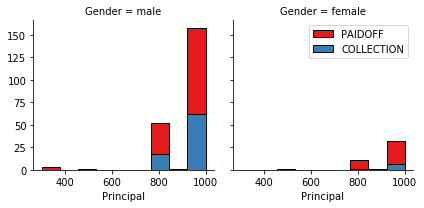

In [37]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

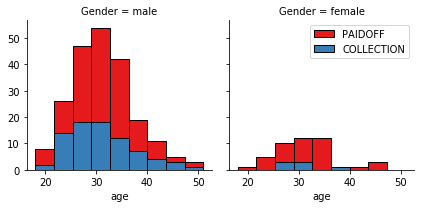

In [38]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

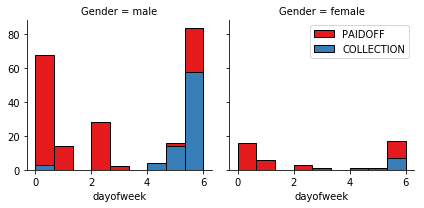

In [39]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


Let's see how month wise stats change with respect to gender

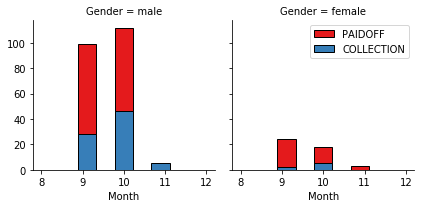

In [40]:
df['Month'] = df.due_date.dt.month
bins = np.linspace(df.Month.min()-1, df.Month.max()+1, 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Month', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [41]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,Month,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,10,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,10,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,9,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,10,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,10,1


## Convert Categorical features to numerical values

Lets look at gender:

In [42]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [43]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,Month,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,10,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,10,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,9,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,10,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,10,1


In [44]:
df['deadline'] = df['due_date'] - df['effective_date']
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,Month,weekend,deadline
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,10,0,29 days
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,10,0,29 days
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,9,0,14 days
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,10,1,29 days
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,10,1,29 days


In [45]:
df['deadline'] = df['deadline'].dt.days
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,Month,weekend,deadline
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,10,0,29
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,10,0,29
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,9,0,14
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,10,1,29
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,10,1,29


## One Hot Encoding  
#### How about education?

In [46]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [47]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [92]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [93]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [94]:
y = df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1]).values
y[0:5]

array([ 0.,  0.,  0.,  0.,  0.])

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [95]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

<h1>Importing accuracy metrics to check with train data</h1>

In [140]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [141]:
#Just using these variables to imporve readability and to stick with classic naming conventions
X_train, y_train = X,y

In [142]:
#A Dicitionary to hold the scores from the train set
train_Scores = {}

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

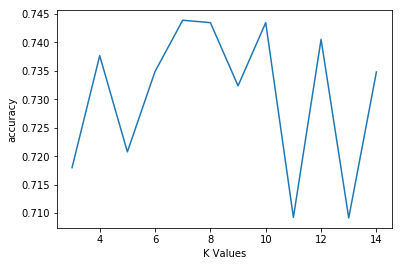

Best K is : 7 
Cross validation Accuracy : 0.743865546218


In [143]:
from sklearn.neighbors import KNeighborsClassifier
bestScore = 0.0
ScoreList = []
K_vals = []
for k in range(3,15):
    clf_knn = KNeighborsClassifier(n_neighbors=k,algorithm='auto')
    scores = cross_val_score(clf_knn, X, y, cv=10)
    score = scores.mean()
    K_vals.append(k)
    ScoreList.append(score)
    if score > bestScore:
        bestScore=score
        best_clf=clf_knn
        bestK=k
#plotting k values to check for the best k
plt.plot(K_vals,ScoreList)
plt.xlabel("K Values")
plt.ylabel("accuracy")
plt.show()
print("Best K is :",bestK,"\nCross validation Accuracy :",bestScore)
clf_knn=best_clf



<h1>Training the KNN Classifier and calculating the accuracy<h1>

In [144]:
clf_knn.fit(X_train,y_train)
y_pred = best_clf.predict(X_train)
KNN_JAC = jaccard_similarity_score(y_train,y_pred)
KNN_F1 = f1_score(y_train,y_pred,average="weighted")
train_Scores['KNN_Jaccard'] = KNN_JAC
train_Scores['KNN_F1'] = KNN_F1
print(train_Scores)

{'KNN_Jaccard': 0.80924855491329484, 'KNN_F1': 0.79557648763062039}


# Decision Tree

In [145]:
from sklearn import tree
clf_tree = tree.DecisionTreeClassifier()


In [146]:
clf_tree = clf_tree.fit(X_train,y_train)

In [147]:
y_pred = clf_tree.predict(X_train)
DT_JAC = jaccard_similarity_score(y_train,y_pred)
DT_F1 = f1_score(y_train,y_pred,average="weighted")
train_Scores['DecisionTree_Jaccard'] = DT_JAC
train_Scores['DecisionTree_F1'] = DT_F1
train_Scores

{'DecisionTree_F1': 0.88707486959086912,
 'DecisionTree_Jaccard': 0.89306358381502893,
 'KNN_F1': 0.79557648763062039,
 'KNN_Jaccard': 0.80924855491329484}

# Support Vector Machine

In [148]:
from sklearn import svm

In [149]:
y_train = y_train.astype(float)
clf_svm = svm.LinearSVC(random_state = 7)
clf_svm.fit(X_train,y_train)
y_pred = clf_svm.predict(X_train)

In [150]:
SVM_JAC = jaccard_similarity_score(y_train,y_pred)
SVM_F1 = f1_score(y_train,y_pred,average="weighted")
train_Scores['SVM_Jaccard'] = SVM_JAC
train_Scores['SVM_F1'] = SVM_F1
train_Scores

{'DecisionTree_F1': 0.88707486959086912,
 'DecisionTree_Jaccard': 0.89306358381502893,
 'KNN_F1': 0.79557648763062039,
 'KNN_Jaccard': 0.80924855491329484,
 'SVM_F1': 0.64413169137974358,
 'SVM_Jaccard': 0.73988439306358378}

# Logistic Regression

In [151]:
from sklearn.linear_model import LogisticRegression

In [152]:
clf_log = LogisticRegression(random_state = 0, solver = 'lbfgs', multi_class = 'multinomial')
clf_log.fit(X_train,y_train)
y_pred = clf_log.predict(X_train)
y_proba = clf_log.predict_proba(X_train)

In [153]:
train_Scores['LogReg_Jaccard']=jaccard_similarity_score(y_train, y_pred)
train_Scores['LogReg_F1']=f1_score(y_train, y_pred, average='weighted')  
train_Scores['LogReg_logLoss']=log_loss(y_train, y_proba)
train_Scores

{'DecisionTree_F1': 0.88707486959086912,
 'DecisionTree_Jaccard': 0.89306358381502893,
 'KNN_F1': 0.79557648763062039,
 'KNN_Jaccard': 0.80924855491329484,
 'LogReg_F1': 0.69972912831050582,
 'LogReg_Jaccard': 0.75433526011560692,
 'LogReg_logLoss': 0.47059973361266266,
 'SVM_F1': 0.64413169137974358,
 'SVM_Jaccard': 0.73988439306358378}

# Model Evaluation using Test set

In [156]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score


First, download and load the test set:

In [157]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-05-15 05:52:24--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-05-15 05:52:25 (516 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [158]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [159]:
#a dictionary to hold the test set scores
test_Scores = {}

In [162]:
test_df = pd.read_csv('loan_train.csv')

test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

test_df['loan_status'].value_counts()

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)
test_df[['Principal','terms','age','Gender','education']].head()
TestFeature = test_df[['Principal','terms','age','Gender','weekend']]
TestFeature = pd.concat([TestFeature,pd.get_dummies(test_df['education'])], axis=1)
TestFeature.drop(['Master or Above'], axis = 1,inplace=True)
TestFeature.head()
test_x = TestFeature

test_y = test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1]).values
test_y = test_y.astype(float)

test_x = preprocessing.StandardScaler().fit(test_x).transform(test_x)

In [163]:
knn_pred=clf_knn.predict(test_x)
test_Scores['KNN-jaccard'] = jaccard_similarity_score(test_y, knn_pred)
test_Scores['KNN-f1-score'] = f1_score(test_y, knn_pred, average='weighted')

In [164]:
dt_pred = clf_tree.predict(test_x)
test_Scores['DecisionTree-jaccard'] = jaccard_similarity_score(test_y, dt_pred)
test_Scores['DecisionTee-f1'] = f1_score(test_y, dt_pred, average="weighted")

In [165]:
svm_pred = clf_svm.predict(test_x)
test_Scores['SVM-jaccard'] = jaccard_similarity_score(test_y, svm_pred)
test_Scores['SVM-f1'] = f1_score(test_y, svm_pred, average='weighted')

In [166]:
log_pred = clf_log.predict(test_x)
proba = clf_log.predict_proba(test_x)
test_Scores['LogisticReg-jaccard'] = jaccard_similarity_score(test_y, log_pred)
test_Scores['LogisticReg-f1'] = f1_score(test_y, log_pred, average="weighted")
test_Scores['LogisticReg-logLoss'] = log_loss(test_y,proba)


In [167]:
train_Scores

{'DecisionTree_F1': 0.88707486959086912,
 'DecisionTree_Jaccard': 0.89306358381502893,
 'KNN_F1': 0.79557648763062039,
 'KNN_Jaccard': 0.80924855491329484,
 'LogReg_F1': 0.69972912831050582,
 'LogReg_Jaccard': 0.75433526011560692,
 'LogReg_logLoss': 0.47059973361266266,
 'SVM_F1': 0.64413169137974358,
 'SVM_Jaccard': 0.73988439306358378}

In [168]:
test_Scores

{'DecisionTee-f1': 0.88707486959086912,
 'DecisionTree-jaccard': 0.89306358381502893,
 'KNN-f1-score': 0.79557648763062039,
 'KNN-jaccard': 0.80924855491329484,
 'LogisticReg-f1': 0.69972912831050582,
 'LogisticReg-jaccard': 0.75433526011560692,
 'LogisticReg-logLoss': 0.47059973361266266,
 'SVM-f1': 0.64413169137974358,
 'SVM-jaccard': 0.73988439306358378}

In [173]:
Test_F1 = []
keys = test_Scores.keys()
for i in keys:
    ptr = str(i)
    if 'f1' in ptr:
        Test_F1.append(test_Scores[ptr])
Test_F1

[0.69972912831050582,
 0.88707486959086912,
 0.79557648763062039,
 0.64413169137974358]

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.809       | 0.795        | NA      |
| Decision Tree      | 0.893       | 0.887        | NA      |
| SVM                | 0.739       |         | NA      |
| LogisticRegression | ?       | ?        | ?       |
